In [1]:
import pickle
import time
import numpy as np
import sys
import pylab
import math
import random as rand
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from DQN_Agent import DQNAgent


# Train

In [2]:
if __name__ == '__main__':
    model_path = '2nd_512_model'
    visualize = True
    if visualize:
        from render import Env_visualize as Env
    else:
        from render import Env_for_train as Env
    env = Env()
    state_size = 16
    action_size = 4
    load_model = False
    agent = DQNAgent(state_size, action_size, load_model, model_path, visualize)
    Top = -np.inf
    TopScore = -np.inf
    scores, episodes = [], []
    loss_list = []
    EPISODES=5000
    for e in range(EPISODES):
        done=False
        score = 0
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        maxScore = -np.inf
        move = 0
        while not done:
            env.render()
            move += 1
            # get action for the current state and go one step in environment
            action = agent.get_action(state, env)
            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            agent.append_sample(state, action, reward, next_state, done)
            if agent.load_model is False and (len(agent.memory) >= agent.train_start):
                agent.train_model()
                
            score += reward
            state = next_state
            if(reward > maxScore):
                maxScore = reward
            if done:
                # every episode update the target model to be same with model
                if agent.load_model is False:
                    agent.update_target_model()
                loss_list.append(agent.train_loss/move)
                scores.append(score)
                episodes.append(e)
                print("episode:", e, "  score:", score, " move:", move,"  memory length:", len(agent.memory), "  epsilon:", agent.epsilon, ' loss:', agent.train_loss/move)
                if (maxScore > Top) and not (load_model):
                    Top = maxScore
                    print('Weights save... Top reward = {}'.format(maxScore))
                    torch.save(agent.model.state_dict(), './save_model/topReward.pth')
                if (score > TopScore) and not (load_model):
                    TopScore = score
                    print('Weights save... Top score = {}'.format(TopScore))
                    torch.save(agent.model.state_dict(), './save_model/topScore.pth')
    print('Weights save... last_model')
    torch.save(agent.model.state_dict(), './save_model/last_model.pth')
    pylab.plot(episodes, scores, 'b')
    pylab.title('Score per episode')
    pylab.savefig('save_plt/Learning_rate={},epsilon_min={},Discount_factor={},episod={}.png'.format(agent.learning_rate, agent.epsilon_min, agent.discount_factor, e+1), dpi=300, facecolor='w')
         

episode: 0   score: 1756  move: 169   memory length: 169   epsilon: 1.0  loss: 0.0
Weights save... Top reward = 144
Weights save... Top score = 1756
episode: 1   score: 392  move: 66   memory length: 235   epsilon: 1.0  loss: 0.0
episode: 2   score: 1604  move: 159   memory length: 394   epsilon: 1.0  loss: 0.0
episode: 3   score: 432  move: 61   memory length: 455   epsilon: 1.0  loss: 0.0
episode: 4   score: 932  move: 115   memory length: 570   epsilon: 1.0  loss: 0.0
episode: 5   score: 1352  move: 139   memory length: 709   epsilon: 1.0  loss: 0.0
episode: 6   score: 704  move: 94   memory length: 803   epsilon: 1.0  loss: 0.0
episode: 7   score: 268  move: 51   memory length: 854   epsilon: 1.0  loss: 0.0
episode: 8   score: 1436  move: 148   memory length: 1002   epsilon: 1.0  loss: 0.0
episode: 9   score: 2324  move: 195   memory length: 1197   epsilon: 0.9982615042374522  loss: nan
Weights save... Top reward = 256
Weights save... Top score = 2324
episode: 10   score: 1024  mov

c:\Users\Hyuk\Desktop\Github\2048_reinforcement\DQN_Agent.py:79: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  state = torch.tensor([state], dtype =torch.float32).reshape(-1,1,4,4).to(self.device)


episode: 14   score: 1200  move: 119   memory length: 1733   epsilon: 0.9929251102048546  loss: nan
episode: 15   score: 840  move: 100   memory length: 1833   epsilon: 0.9919326764320667  loss: nan
episode: 16   score: 1420  move: 146   memory length: 1979   epsilon: 0.9904855041814195  loss: nan
episode: 17   score: 600  move: 80   memory length: 2059   epsilon: 0.9896934286901347  loss: nan
episode: 18   score: 1496  move: 154   memory length: 2213   epsilon: 0.9881704661772576  loss: nan
episode: 19   score: 1408  move: 146   memory length: 2359   epsilon: 0.9867287827731934  loss: nan


KeyboardInterrupt: 

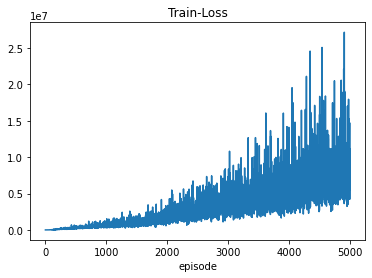

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_list)
plt.title("Train-Loss")
plt.xlabel("episode")
plt.savefig('./save_plt/2nd_512_model_loss.png', dpi=300, facecolor='w')
np.save('loss_list',loss_list)

# Test

In [ ]:
if __name__ == '__main__':
    model_path = 'up'
    env = Env()
    state_size = 16
    action_size = 4
    load_model = True
    agent = DQNAgent(state_size, action_size, load_model, model_path)
    Top = -np.inf
    scores, episodes = [], []
    lossss = []
    EPISODES=2000
    for e in range(EPISODES):
        done=False
        score = 0
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        maxScore = -np.inf
        move =0
        while not done:
#             if agent.render:
            env.render()
            move+=1
            # get action for the current state and go one step in environment
            action = agent.get_action(state, env)
#             print(np.array(env.board))
            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            if done:
                doneReward = -1024
                agent.append_sample(state, action, doneReward, next_state, done)
            else:
                agent.append_sample(state, action, reward, next_state, done)
            # if an action make the episode end, then gives penalty of -100
#             reward = reward if not done or score == 499 else agent.penalty
#             print({0 : 'left', 1:'up' , 2:'right', 3:'down'}[action])
            # save the sample <s, a, r, s'> to the replay memory
            # every time step do the training
            if (len(agent.memory) >= agent.train_start):
                agent.train_model()

            score += reward
            state = next_state
            if(reward > maxScore):
                maxScore = reward
            if done:
                # every episode update the target model to be same with model
                agent.update_target_model()
                loss_list.append(agent.train_loss/move)
                scores.append(score)
                episodes.append(e)
                print("episode:", e, "  score:", score, " move:", move,"  memory length:", len(agent.memory), "  epsilon:", agent.epsilon, ' loss:', agent.train_loss/move)
                if (maxScore > Top):
                    Top = maxScore
                    print('Weights save... Top reward = {}'.format(maxScore))
                    torch.save(agent.model.state_dict(), './save_model/up_topReward.pth')
                if (score > Top):
                    Top = score
                    print('Weights save... Top score = {}'.format(TopScore))
                    torch.save(agent.model.state_dict(), './save_model/up_topScore.pth')
    print('Weights save... lastest_model')
    torch.save(agent.model.state_dict(), './save_model/up_last_model.pth')
    pylab.plot(episodes, scores, 'b')
    pylab.title('Score per episode')
    pylab.savefig('save_plt/up_Learning_rate={},epsilon_min={},Discount_factor={},episod={}.png'.format(agent.learning_rate, agent.epsilon_min, agent.discount_factor, e+1), dpi=300, facecolor='w')
   

Model_loaded...
episode: 0   score: 2224  move: 211   memory length: 211   epsilon: 0.01  loss: 0.0
Weights save... Top reward = 128
episode: 1   score: 5080  move: 361   memory length: 572   epsilon: 0.01  loss: 0.0
Weights save... Top reward = 520
episode: 2   score: 2396  move: 222   memory length: 794   epsilon: 0.01  loss: 0.0
episode: 3   score: 1076  move: 113   memory length: 907   epsilon: 0.01  loss: 0.0
episode: 4   score: 3776  move: 310   memory length: 1217   epsilon: 0.01  loss: 2231.750972230973
episode: 5   score: 808  move: 100   memory length: 1317   epsilon: 0.01  loss: 10483.783881835938
episode: 6   score: 2336  move: 217   memory length: 1534   epsilon: 0.01  loss: 8708.866030363442
episode: 7   score: 3064  move: 248   memory length: 1782   epsilon: 0.01  loss: 11459.052261352539
episode: 8   score: 1384  move: 141   memory length: 1923   epsilon: 0.01  loss: 24386.912014142843
episode: 9   score: 3116  move: 255   memory length: 2178   epsilon: 0.01  loss: 1785

RuntimeError: CUDA error: unspecified launch failure

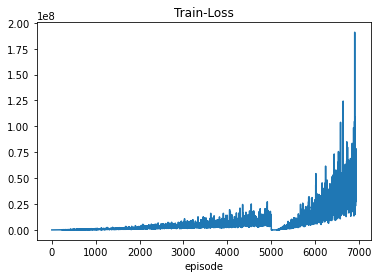

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_list)
plt.title("Train-Loss")
plt.xlabel("episode")
plt.savefig('./save_plt/1st_1024_model_trainloss.png', dpi=300, facecolor='w')
np.save('',loss_list)